# Embed, Encode, Attend and Predict

In [1]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import custom_attn
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe Embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [5]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [6]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [7]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(18846, 40, 60)


In [8]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

### Sentence Level

In [10]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")

sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     weights=[E])(sent_inputs)
sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
                             return_sequences=True))(sent_emb)

sent_vec = GlobalMaxPooling1D()(sent_enc)
sent_att = custom_attn.AttentionMV()([sent_enc, sent_vec])

sent_model = Model(inputs=sent_inputs, outputs=sent_att)

# sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
#                              return_sequences=False))(sent_emb)

# sent_model = Model(inputs=sent_inputs, outputs=sent_enc)

sent_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 60)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 60, 300)       12219000    input_1[0][0]                    
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 60, 200)       240600      embedding_1[0][0]                
____________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalMa (None, 200)           0           bidirectional_1[0][0]            
___________________________________________________________________________________________

In [11]:
doc_inputs = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")

doc_emb = TimeDistributed(sent_model)(doc_inputs)

doc_enc = Bidirectional(GRU(DOC_EMBED_SIZE,
                            return_sequences=True))(doc_emb)

doc_vec = GlobalMaxPooling1D()(doc_enc)
doc_att = custom_attn.AttentionMV()([doc_enc, doc_vec])

fc1_dropout = Dropout(0.2)(doc_att)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
doc_pred = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=doc_inputs, outputs=doc_pred)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 40, 60)        0                                            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistribu (None, 40, 200)       12471860    input_2[0][0]                    
____________________________________________________________________________________________________
bidirectional_2 (Bidirectional)  (None, 40, 100)       75300       time_distributed_1[0][0]         
____________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalMa (None, 100)           0           bidirectional_2[0][0]            
___________________________________________________________________________________________

In [12]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [13]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/10
11872/11872 [==============================] - 143s - loss: 2.6603 - acc: 0.1515 - val_loss: 1.7490 - val_acc: 0.4455
Epoch 2/10
11872/11872 [==============================] - 142s - loss: 1.2612 - acc: 0.5948 - val_loss: 0.9111 - val_acc: 0.7242
Epoch 3/10
11872/11872 [==============================] - 141s - loss: 0.6531 - acc: 0.7953 - val_loss: 0.7710 - val_acc: 0.7682
Epoch 4/10
11872/11872 [==============================] - 141s - loss: 0.3494 - acc: 0.8985 - val_loss: 0.7463 - val_acc: 0.7864
Epoch 5/10
11872/11872 [==============================] - 141s - loss: 0.1852 - acc: 0.9506 - val_loss: 0.7559 - val_acc: 0.8038
Epoch 6/10
11872/11872 [==============================] - 141s - loss: 0.0943 - acc: 0.9752 - val_loss: 0.8884 - val_acc: 0.8061
Epoch 7/10
11872/11872 [==============================] - 141s - loss: 0.0494 - acc: 0.9902 - val_loss: 0.9145 - val_acc: 0.7917
Epoch 8/10
11872/11872 [========================

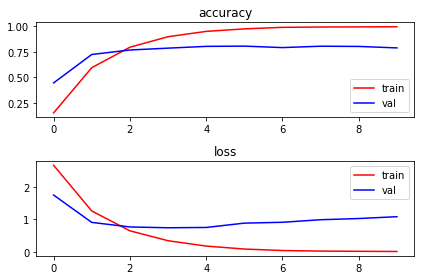

In [14]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [15]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.820

confusion matrix

[[183   1   0   0   0   1   1   0   2   0   0   0   1   0   0   2   3   3   4  38]
 [  2 206  21  14   4  12  15   3   2   2   1   0   8   1   5   1   0   0   0   2]
 [  1  23 207  17   5   8   1   0   0   0   2   0   4   1   1   0   1   0   0   0]
 [  0  16  26 213  16   3  10   1   2   1   0   2   9   0   0   0   4   1   2   0]
 [  0   5   8  29 224   1  15   1   1   1   0   3   9   1   0   1   1   0   2   0]
 [  2  35  16   9   0 229   0   2   1   0   2   1   0   1   1   0   0   0   1   0]
 [  1   3   8   8  14   5 231   5   2   0   3   0   5   0   3   0   0   0   3   2]
 [  2   0   2   0   5   1   7 238   6   2   3   1   5   0   1   0   1   0   1   2]
 [  0   0   0   2   0   0   2   6 297   2   4   0   4   0   1   0   3   0   1   0]
 [  0   0   0   3   1   0   1   2   3 261  33   0   0   2   0   3   0   1   3   2]
 [  0   0   1   3   1   0   5   0   3   6 261   0   0   0   2   0   1   0   3   0]
 [  1   3   2   2   0   1   1   1   1   0   0 